In [1]:
!pip install unidecode

     |████████████████████████████████| 241 kB 4.3 MB/s 


# Created by Adriano A. Batista, 2020 and adapted by Jefferson H. Bezerra, 2021.
# activeWorld.py -- Model epidemiological data from any country in the world



#**BRASIL**


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,5,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,3,5,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


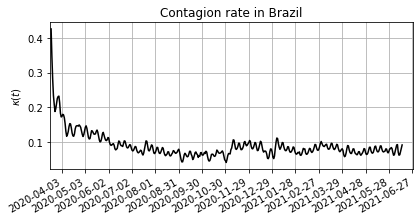

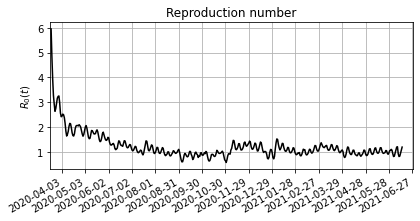

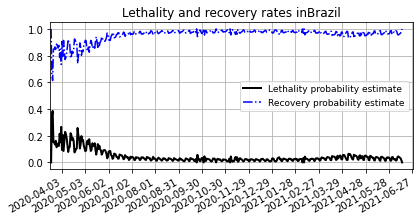

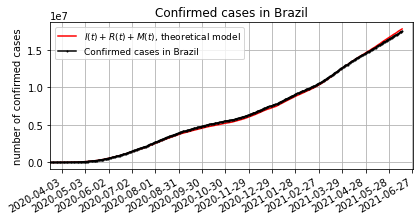

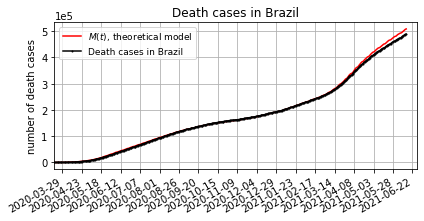

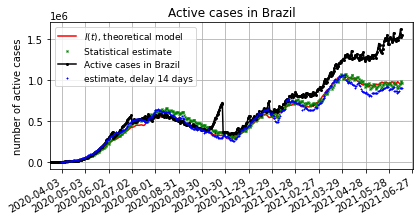

In [2]:
# -*- coding: utf-8 -*-
# Author: Adriano A. Batista, 2020
# activeWorld.py -- Model epidemiological data from any country in the world
#
'''
 command line:
   python3 activeWorld.py configCountry.txt

 Input: 
   csv data files:
      time_series_covid19_confirmed_global_narrow.csv
      time_series_covid19_deaths_global_narrow.csv
      time_series_covid19_recovered_global_narrow.csv
 Esses arquivos podem ser obtidos do site:
    https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
 configCountry.txt file example:
    country,Brazil
    delay,14
    offset,22
    cutoff,0.43
 Output
 1. confirmed, recovered, death, and active cases plots of comparison 
    between data and corresponding model curve fits.
 2. contagion rate time series, Rt, and lethality probability
'''
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import scipy.integrate
from scipy import stats
from scipy.interpolate import UnivariateSpline
import pandas as pd
import numpy as np
import sys
import time
from datetime import timedelta
from collections import OrderedDict
import unidecode

plt.rcParams['axes.grid'] = True

dados = np.array([['country','Brazil'],
       ['delay', '14'],
       ['offset', '22'],
       ['cutoff', '0.425']])
def read_setup(inSetupFile):
  # open SIRD model parameter data 
  # Format of setup file
  # parameter      value
  '''
  country             country name
  delay               tau
  offset              another delay
  cutoff              maximum value of  kappa(t)
  '''
  global country, delay, offset, cutoff
  # Read setup file
  lines = dados
  # build a dictionary
  setup_vars = OrderedDict(lines)

  for var in lines:
    if var[0] == 'country':
      setup_vars[var[0]] = var[1]
    else:
      if var[1].isdigit():
        setup_vars[var[0]] = int(var[1])
      else:
        setup_vars[var[0]] = float(var[1])
  # Transform the keys into variables
  globals().update(setup_vars)
read_setup(sys.argv[1])
# create log file
logFile = 'log'+country+'.txt'
f = open(logFile, 'w')
f.write('country %s, delay %d, offset %d, cutoff %g\n' %(country, delay, offset,
  cutoff))
##########################################################

# 1. Data processing
csvFiles = ['/content/drive/MyDrive/time_series_covid19_confirmed_global_narrow.csv',
            '/content/drive/MyDrive/time_series_covid19_deaths_global_narrow.csv',
            '/content/drive/MyDrive/time_series_covid19_recovered_global_narrow.csv']

# a. Open confirmed datafile create dataframe
df = pd.read_csv(csvFiles[0], sep =',', skiprows=0, header=0, names=["ProvinceState", "Country/Region", "Lat", "Long", "Date", "Value", "ISO 3166-1 Alpha 3-Codes", "Region Code", "Sub-region Code", "Intermediate Region Code"])
# Filter country data
df = df[df['Country/Region'].str.contains(country)]
df = df.sort_values('Date', ascending=True)
confirmed = df.Value.to_numpy().astype(int)
ind0 = (confirmed!=0).argmax() # first nonzero index of confirmed
ind0 += offset
confirmed = confirmed[ind0:] # cut off the leading zeros
f.write('ind0 %d, offset %d\n' % (ind0, offset))
dates = pd.to_datetime(df.Date) # covert string dates to datetime format
dates = dates[ind0:]
# b. Open deaths datafile, create dataframe.
df = pd.read_csv(csvFiles[1], sep =',', skiprows=0, header=0, names=["ProvinceState", "Country/Region", "Lat", "Long", "Date", "Value", "ISO 3166-1 Alpha 3-Codes", "Region Code", "Sub-region Code", "Intermediate Region Code"])
df = df[df['Country/Region'].str.contains(country)]
deaths = df.Value.to_numpy().astype(int)
deaths = deaths[::-1]
deaths = deaths[ind0:]
indFirstDeath = (deaths!=0).argmax()
f.write('indFirstDeath %d, First death on %s, number of deaths %d\n'
  % (indFirstDeath, dates.iloc[indFirstDeath], deaths[indFirstDeath]))
# c. Open recovered datafile, create dataframe.
df = pd.read_csv(csvFiles[2], sep =',', skiprows=0, header=0, names=["ProvinceState", "Country/Region", "Lat", "Long", "Date", "Value", "ISO 3166-1 Alpha 3-Codes", "Region Code", "Sub-region Code", "Intermediate Region Code"])
df = df[df['Country/Region'].str.contains(country)]
recovered = df.Value.to_numpy().astype(int)
recovered = recovered[::-1]
recovered = recovered[ind0:]

# d. generate active cases from data
activeCases = confirmed-deaths-recovered

P_0 = int(211049527)
f.write('População em 2019 %d\n' % (P_0))

# 2. Statistical analysis
# Active cases delay estimate
activeDelay = confirmed[delay:]-confirmed[:-delay]
n_avg=delay

day = 24 # day in hours
dt = 1.0/day  # integration time-step
tau = round((1+n_avg*day)*dt) # average time duration of infection
nu = 3.7844e-5
mu = 1.6918e-5

# Active cases statistical estimate
q = n_avg/(1+n_avg) # probability to remain sick after 1 day
newConf = np.diff(confirmed) # casos novos confirmados ao dia
newDead = np.diff(deaths) # casos novos confirmados ao dia
N = len(newConf)
activeStat = np.ones(N)
n_pow = np.arange(N)
n_pow1 = n_pow[1:]
n_pow_des = n_pow[::-1]
q_to_n = q**n_pow_des
for i in n_pow:
  activeStat[i] = np.sum(newConf[:i]*q_to_n[N-i:])

# 3. Parameter estimation
# A. Contagion rate function
susceptible = (P_0-confirmed)/P_0
contagionRate = []
N_as = len(activeStat)
for i in np.arange(0, N_as):
  if i+7<=N_as:
    XX = np.arange(i, i+7)
    ZZ = activeStat[i:i+7]
  else:
    XX = np.arange(i-7, i)
    ZZ = activeStat[i-7:i]
  if len(XX)==len(ZZ):
    slope, intercept, r_value, p_value, std_err = stats.linregress(XX, ZZ)
    I_avg = np.sum(ZZ)/7
    if I_avg==0:
      ka_t=0
    else:
      ka_t =(1/susceptible[i])*(slope/I_avg+1.0/tau+mu)
    if ka_t<0:
      ka_t = 0
    elif ka_t> cutoff:
      ka_t = cutoff
    contagionRate.append(ka_t)

##########################################################
def kappa(t):
  ind = int(1.0*t)
  N=len(contagionRate)
  if ind>=N:
    ind = N-1
  ka = contagionRate[ind]
  if ind>0 and ind<N and ka==0:
    ka = (contagionRate[ind-1]+contagionRate[ind+1])/2
  return ka
##########################################################
# vectorize contagion rate
kappa_t_vec = []
n_max = len(confirmed)-1 # in days
tt = np.arange(0.0, n_max, dt)
for ind, t in enumerate(tt[::day]):
  ka = kappa(t)
  kappa_t_vec.append(ka)
kappa_t_vec = np.array(kappa_t_vec)

# C. Lethality probability
P_let = np.zeros(N)
for i in n_pow[:-1]:
    denom = np.sum(newConf[:i]*q_to_n[N-i:])
    if denom>0:
      s = newDead[i]/denom
    else:
      s=0
    P_let[i] = s/(1-q)
# Lethality and recovery rates
letRate = P_let/tau
rho = 1.0/tau-letRate
P_rho=1-P_let

# 4. Numerical model epidemic evolution (modified SIR model)
##########################################################
def get_l_r(t):
  ind = int(1.0*t)
  N=len(P_let)
  if ind>=N:
    ind = N-1
  la = P_let[ind]/tau
  rho = 1.0/tau - la
  return la, rho
##########################################################
def derivs (x, t): # return derivatives of the array x
   S = x[0] # susceptíveis
   I = x[1] # infectados
   R = x[2] # Recuperados
   M = x[3] # Mortos
   T = S+I+R
   l, r = get_l_r(t)
   dSdt = nu*T-mu*S-kappa(t)*S*I
   dIdt = -mu*I+kappa(t)*S*I-r*I-l*I
   dRdt = r*I-mu*R
   dMdt = l*I
   return [dSdt, dIdt, dRdt, dMdt]
##########################################################
C_0 = confirmed[0]
R_0 = recovered[0]
D_0 = deaths[0]
A_0 = C_0-R_0-D_0
f.write('C_0 %g, A_0 %g, R_0 %g, D_0 %g\n' % (C_0, A_0, R_0, D_0))
yinit = [1.0-C_0/P_0, A_0/P_0, R_0/P_0, D_0/P_0] # initial values

y = scipy.integrate.odeint(derivs, yinit, tt)
S = y[:, 0]
I = y[:, 1]
R = y[:, 2]
M = y[:, 3]

#################### GENERATE R(t) #######################

R0_t = tau*kappa_t_vec*S[::day]

#################### Plot results ######################

############## Contagion rate estimate #################

fig1, ax1 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

ax1.plot(dates[1:], kappa_t_vec, 'k-', ms=2)

ax1.set_ylabel(r'$\kappa(t)$')
ax1.set_title('Contagion rate in %s' % country)

delta = timedelta(days=14)
ax1.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

figure = f'{country}: Kappa.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
fig1.savefig(figure, bbox_inches='tight')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

######### DYNAMIC REPRODUCTIVE NUMBER R_0(t)##########

fig2, ax2 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

ax2.plot(dates[1:], R0_t, 'k-')
ax2.set_ylabel(r'$R_0(t)$')
ax2.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax2.set_title('Reproduction number')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

figure = f'{country}: Reproduction number.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

########### Lethality probability, P_lambda(t), and recovery probability, P_rho(t) #######

fig3, ax3 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

ax3.plot(dates[1:], P_let, 'k-', linewidth=2.0, label="Lethality probability estimate")
ax3.plot(dates[1:], P_rho, 'b-.', linewidth=1.5,  label="Recovery probability estimate")

#ax3.set_xlabel()
#ax3.set_ylabel()

ax3.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax3.set_ylim()

ax3.set_title(u'Lethality and recovery rates in%s' % (country))

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{country}: Lethality_and_recovery_rates.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

##############  CONFIRMED CASES ################

fig4, ax4 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

C= P_0*(I+R+M)
ax4.plot(dates[1:], C[::day], 'r-', label=r"$I(t)+R(t)+M(t)$, theoretical model")
ax4.plot(dates, confirmed, 'k-o', ms=1,  label= u"Confirmed cases in %s"  % (country))

#ax.set_xlabel()
ax4.set_ylabel(u'number of confirmed cases')

ax4.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

ax4.set_title(u"Confirmed cases in %s" % (country))

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{country}: Confirmedcases.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')
f.write('%s\n' % figure)

################### DEATHS CASES ###################

fig5, ax5 = plt.subplots(1, figsize=(6.5, 3), sharex=True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) #Deixar em notação científica

ax5.plot(dates[1:], P_0*M[::day], 'r-', label=u"$M(t)$, theoretical model")
ax5.plot(dates, deaths, 'k-o', ms=1,  label= u"Death cases in %s" % (country))

#ax.set_xlabel()
ax5.set_ylabel(u'number of death cases')

ax5.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

ax5.set_title(u"Death cases in %s"  % (country))

ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax5.xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{country}: Death_cases.jpg' 
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')
f.write('%s\n' % figure)

######################  ACTIVE CASES ############################
fig6, ax6 = plt.subplots(1, figsize=(6.5, 3), sharex=True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) #Deixar em notação científica
#ax6.yaxis.set_ticks(np.arange(min(P_0*I[::day]), max(P_0*I[::day])+1, max(P_0*I[::day])/15 ))

ax6.plot(dates[:-1], P_0*I[::day], 'r-', label=u"$I(t)$, theoretical model")
ax6.plot(dates[1:], activeStat, 'gx', ms=2,  label= 'Statistical estimate')
ax6.plot(dates, activeCases, 'k-o', ms=2,  label= u"Active cases in %s" % (country))
ax6.plot(dates[delay:], activeDelay, 'b+', ms=2,  label= 'estimate, delay %d days' % delay)

#ax6.set_xlabel()
ax6.set_ylabel(u'number of active cases')

ax6.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax6.set_ylim()

ax6.set_title(u"Active cases in %s"  % (country))

ax6.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax6.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{country}: Active_cases.jpg' 
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

plt.show()

#**PARAÍBA**

No handles with labels found to put in legend.
No handles with labels found to put in legend.


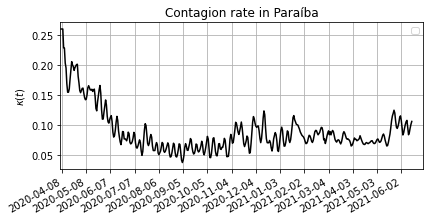

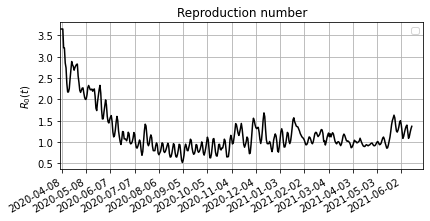

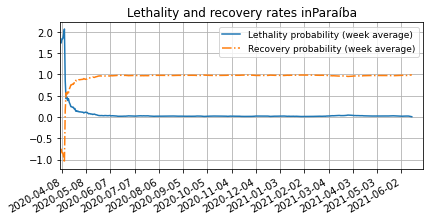

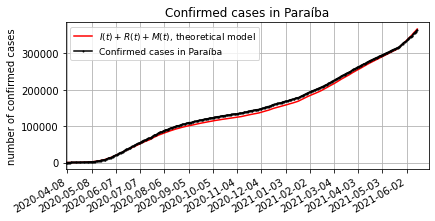

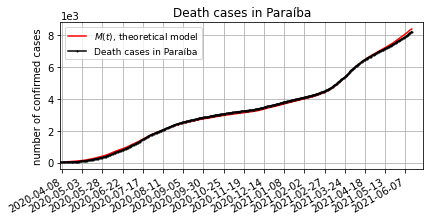

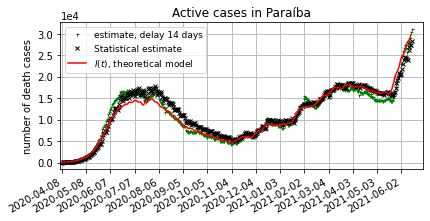

In [3]:
dados = np.array([['state', 'PB'],
       ['city', '_'],
       ['delay', '14'],
       ['offset', '19'],
       ['cutoff', '0.26']])

def read_setup(inSetupFile):
  # open SIRM model parameter data 
  # Format of setup file
  # parameter      value
  '''
  state               nome do estado
  city                nome da cidade
  delay               atraso
  offset              outro atraso
  cutoff              valor máximo de k(t)
  '''
  global state, city, delay, offset, cutoff
  # Read setup file
  lines = dados
  # Crie o dicionario
  setup_vars = OrderedDict(lines)
  for var in lines:
    if var[0] == 'state' or var[0] == 'city':
      setup_vars[var[0]] = var[1]
    else:
      if var[1].isdigit():
        setup_vars[var[0]] = int(var[1])
      else:
        setup_vars[var[0]] = float(var[1])
  # Transform the keys into variables
  globals().update(setup_vars)
read_setup(sys.argv[1])

n_avg=delay 
nu = 3.7844e-05 # taxa de natalidade diária (2018, IBGE) 
mu = 1.6918e-05 # taxa de mortalidade diária (2018, IBGE) 
day = 24 # dia em horas
dt = 1.0/day  # em unidade de dia
tau = (1+n_avg*day)*dt # tempo médio de infecção em dias

estados = {
    'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazônia', 'AP':'Amapá', 
    'BA':'Bahia', 'CE':'Ceará', 'DF':'Distrito Federal', 
    'ES':'Espírito Santo', 'GO':'Goiás', 'MA': 'Maranhão',
    'MG':'Minas Gerais', 'MS':'Mato Grosso do Sul', 'MT':'Mato Grosso',
    'PA':'Pará', 'PB':'Paraíba', 'PR':'Paraná', 'PE':'Pernambuco', 
    'PI':'Piauí', 'RJ':'Rio de Janeiro', 'RN':'Rio Grande do Norte', 
    'RO':'Rondônia', 'RR':'Roraima', 'RS':'Rio Grande do Sul', 
    'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 
    'TO':'Tocantins'}
if city == '_':
  city_state = estados[state]
  city = ''
else:
  city_state = city

# create log file
logFile = 'log'+city+state+'.txt'
# remove white spaces
logFile = logFile.replace(' ','')
f = open(logFile, 'w')
f.write('estado %s, cidade %s, atraso %d, offset %s, cutoff %g\n' 
    % (state,  city, delay, offset, cutoff))
##########################################################
# 1. Data processing
# File caso.csv obtained from the site https://data.brasil.io/dataset/covid19/_meta/list.html
# or download directly with the command:
# wget https://data.brasil.io/dataset/covid19/caso.csv.gz
arquivo_csv = '/content/drive/MyDrive/caso.csv'
Recuperados = pd.read_csv('/content/drive/MyDrive/20210610_150220.csv')
recuperados = Recuperados['recuperados']
dados = pd.read_csv(arquivo_csv, sep =',', skiprows=0, header=0, parse_dates=['date'])
#dados = pd.read_csv(arquivo_csv, sep =',', skiprows=0, header=0, names=['date','state', 'city', 'place_type', 'confirmed', 'deaths','order_for_place','is_last', 'estimated_population_2019', 'estimated_population', 'city_ibge_code', 'confirmed_per_100k_inhabitants', 'death_rate'], parse_dates=['date'])
dados = dados[dados['state'].str.contains(state)]
if city == '':
  dados = dados[dados['city'].isnull()]
else:
  dados = dados[~dados.isin([np.nan]).any(1)]
  dados = dados[dados['city'].str.contains(city)]

dados = dados.sort_values('date', ascending=True)
confirmed = dados['confirmed'].to_numpy().astype(int)
deaths = dados['deaths'].to_numpy().astype(int)
ind0 = (confirmed!=0).argmax()
dates = pd.to_datetime(dados.date)
dates = dates[ind0:]
indFirstDeath = (deaths!=0).argmax()
f.write('indFirstDeath %d, First death on %s, number of deaths %d\n'
  % (indFirstDeath, dates.iloc[indFirstDeath], deaths[indFirstDeath]))
ind0 += offset
confirmed = confirmed[ind0:]
deaths = deaths[ind0:]
f.write('ind0 %d, offset %d\n' % (ind0, offset))
dates = dates[offset:]
P_0 = dados['estimated_population_2019'].to_numpy(dtype=int)[0]
f.write('População em 2019 %d\n' % (P_0))

n_max = len(confirmed)-1 # em dias
tt = np.arange(0.0, n_max, dt)
recuperados = recuperados[len(confirmed):0:-1]
ativos = confirmed-(recuperados+deaths)
# 2. Statistical analysis
# Active cases delay estimate
activeDelay = confirmed[delay:]-confirmed[:-delay]
# Active cases statistical estimate
q = (n_avg)/(1+n_avg) # probability to remain sick after 1 day
newConf = np.diff(confirmed) # casos novos confirmados ao dia
newDead = np.diff(deaths) # casos novos confirmados ao dia
N = len(newConf)
active_stat = np.ones(N)
n_pow = np.arange(N)
n_pow_des = n_pow[::-1]
q_to_n = q**n_pow_des
for i in n_pow:
  active_stat[i] = np.sum(newConf[:i]*q_to_n[N-i:])

# 3. Parameter estimation
# a. Contagion rate function
contagionRate = []
S = (P_0-confirmed)/P_0
N_as = len(active_stat)
for i in np.arange(0, N_as):
  if i+7<=N_as:
    XX = np.arange(i, i+7)
    ZZ = active_stat[i:i+7]
  else:
    XX = np.arange(i-7, i)
    ZZ = active_stat[i-7:i]
  if len(XX)==len(ZZ):
    slope, intercept, r_value, p_value, std_err = stats.linregress(XX, ZZ)
    I_avg = np.sum(ZZ)/7
    if I_avg==0:
      ka_t=0
    else:
      ka_t = (1/S[i])*(slope/I_avg+1.0/tau+mu)
    if ka_t<0:
      ka_t = 0
    elif ka_t>cutoff:
      ka_t = cutoff
    contagionRate.append(ka_t)

##########################################################
# Contagion rate function
##########################################################
def kappa(t):
  ind = int(1.0*t)
  N=len(contagionRate)
  if ind>=N:
    ind = N-1
  ka = contagionRate[ind]
  if ind>0 and ind<N and ka==0:
    ka = (contagionRate[ind-1]+contagionRate[ind+1])/2
  return ka
##########################################################
# Vectorize the contagion rate
kappa_t_vec = []
for ind, t in enumerate(tt[::day]):
  ka = kappa(t)
  kappa_t_vec.append(ka)
kappa_t_vec = np.array(kappa_t_vec)

# Lethality probability
P_let = np.zeros(N)
for i in n_pow[:-1]:
    denom = np.sum(newConf[:i]*q_to_n[N-i:])
    if denom>0:
      s = newDead[i]/denom
    else:
      s=0
    P_let[i] = s/(1-q)
f.write('first P_let avg %g\n' % (np.sum(P_let[:21])/21))
f.write('last P_let avg %g\n' % (np.sum(P_let[-21:])/21))

# week average
Pl_avg = np.convolve(P_let, np.ones((7,))/7, mode='same')
# Lethality and recovery rates
letRate = Pl_avg/tau
recRate = 1.0/tau-letRate

# Numerical model epidemic evolution (modified SIR model)
##########################################################
# Get lethality and recovery rates
def get_l_r(t):
  ind = int(1.0*t)
  N = len(Pl_avg)
  if ind>=N:
    ind = N-1
  la = Pl_avg[ind]/tau
  rho = 1.0/tau - la
  return la, rho
##########################################################
def derivs (x, t): # return derivatives of the array x
   S = x[0] # susceptíveis
   I = x[1] # infectados
   R = x[2] # Recuperados
   M = x[3] # Mortos
   T = S+I+R
   l, r = get_l_r(t)
   dSdt = nu*T-mu*S-kappa(t)*S*I
   dIdt = -mu*I+kappa(t)*S*I-r*I-l*I
   dRdt = r*I-mu*R
   dMdt = l*I
   return [dSdt, dIdt, dRdt, dMdt]
##########################################################
C_0 = confirmed[0]
R_0 = 0.0
D_0 = deaths[0]
A_0 = C_0-R_0-D_0
f.write('C_0 %g, A_0 %g, R_0 %g, D_0 %g\n' % (C_0, A_0, R_0, D_0))
yinit = [1.0-C_0/P_0, A_0/P_0, R_0/P_0, D_0/P_0] # initial values
y = scipy.integrate.odeint(derivs, yinit, tt)
S = y[:, 0]
I = y[:, 1]
R = y[:, 2]
M = y[:, 3]

#################### GENERATE R(t) #######################

R0_t = tau*kappa_t_vec*S[::day]

#################### Plot results ######################

############## Contagion rate estimate #################

fig1, ax1 = plt.subplots(1, figsize=(6.5, 3) , sharex=True)

ax1.plot(dates[1:], kappa_t_vec, 'k-', ms=2)

ax1.set_ylabel(r'$\kappa(t)$')
ax1.set_title('Contagion rate in %s' % city_state)

delta = timedelta(days=14                  )
ax1.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Kappa %s_%s.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')


######### DYNAMIC REPRODUCTIVE NUMBER R_0(t)##########

fig2, ax2 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

ax2.plot(dates[1:], R0_t, 'k-')
ax2.set_ylabel(r'$R_0(t)$')
ax2.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax2.set_title('Reproduction number')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Reproduction number.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

########### Lethality probability, P_lambda(t), and recovery probability, P_rho(t) #######
fig3, ax3 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

ax3.plot(dates[1:], Pl_avg, '-', linewidth=1.5, label="Lethality probability (week average)")
ax3.plot(dates[1:], 1-Pl_avg, '-.', linewidth=1.5,  label="Recovery probability (week average)")

#ax3.set_xlabel()
#ax3.set_ylabel()

ax3.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax3.set_ylim()

ax3.set_title(u'Lethality and recovery rates in%s' % (city_state))

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Lethality_and_recovery_rates .jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

##############  CONFIRMED CASES ################

fig4, ax4 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

C= P_0*(I+R+M)
ax4.plot(dates[1:], C[::day], 'r-', label=r"$I(t)+R(t)+M(t)$, theoretical model")
ax4.plot(dates, confirmed, 'k-o', ms=1,  label= u"Confirmed cases in %s" % (city_state))

#ax.set_xlabel()
ax4.set_ylabel(u'number of confirmed cases')

ax4.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

ax4.set_title(u"Confirmed cases in %s" % (city_state))

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Confirmedcases.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')
f.write('%s\n' % figure)

################### DEATHS CASES ###################

fig5, ax5 = plt.subplots(1, figsize=(6.5, 3), sharex=True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) #Deixar em notação científica

ax5.plot(dates[1:], P_0*M[::day], 'r-', label=u"$M(t)$, theoretical model")
ax5.plot(dates, deaths, 'k-o', ms=1,  label= u"Death cases in %s" % (city_state))

#ax.set_xlabel()
ax5.set_ylabel(u'number of confirmed cases')

ax5.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

ax5.set_title(u"Death cases in %s" % (city_state))

ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax5.xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Death_cases.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')
f.write('%s\n' % figure)

######################  ACTIVE CASES ############################
fig6, ax6 = plt.subplots(1, figsize=(6.5, 3), sharex=True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) #Deixar em notação científica
#ax6.yaxis.set_ticks(np.arange(min(P_0*I[::day]), max(P_0*I[::day])+1, max(P_0*I[::day])/15 ))

ax6.plot(dates[delay:], activeDelay, 'g+', ms=3,  label= 'estimate, delay %d days' % delay)
ax6.plot(dates[1:], active_stat, 'kx', ms=4,  label= 'Statistical estimate')
ax6.plot(dates[:-1], P_0*I[::day], 'r-', label=u"$I(t)$, theoretical model")

#ax6.set_xlabel()
ax6.set_ylabel(u'number of death cases')

ax6.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax6.set_ylim()

ax6.set_title(u"Active cases in %s" % (city_state))

ax6.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax6.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Active_cases.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

plt.show()

#**CAMPINA GRANDE**

No handles with labels found to put in legend.


P_let


No handles with labels found to put in legend.


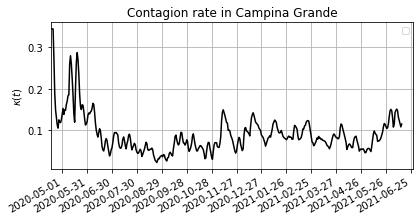

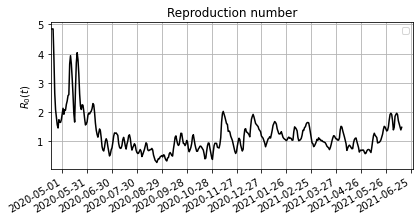

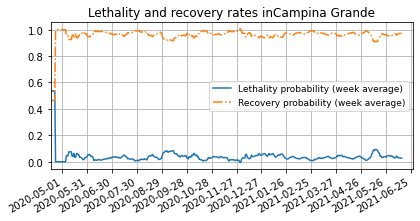

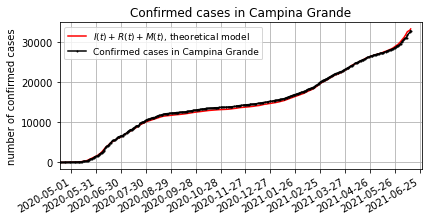

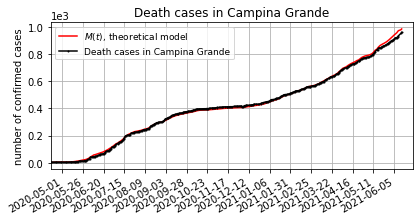

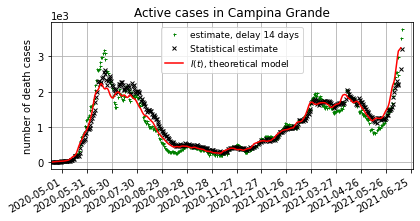

In [4]:
dados = np.array([['state', 'PB'],
  ['city', 'Campina Grande'],
  ['delay','14'],
  ['offset','21'],
  ['cutoff', '0.345']])

def read_setup(inSetupFile):
  # open SIRM model parameter data 
  # Format of setup file
  # parameter      value
  '''
  state               nome do estado
  city                nome da cidade
  delay               atraso
  offset              outro atraso
  cutoff              valor máximo de k(t)
  '''
  global state, city, delay, offset, cutoff
  # Read setup file
  lines = dados
  # Crie o dicionario
  setup_vars = OrderedDict(lines)
  #print setup_vars.items()
  for var in lines:
    if var[0] == 'state' or var[0] == 'city':
      setup_vars[var[0]] = var[1]
    else:
      if var[1].isdigit():
        setup_vars[var[0]] = int(var[1])
      else:
        setup_vars[var[0]] = float(var[1])
  # Transform the keys into variables
  globals().update(setup_vars)
read_setup(sys.argv[1])

n_avg=delay 
nu = 3.7844e-05 # taxa de natalidade diária (2018, IBGE) 
mu = 1.6918e-05 # taxa de mortalidade diária (2018, IBGE) 
day = 24 # dia em horas
dt = 1.0/day  # em unidade de dia
tau = (1+n_avg*day)*dt # tempo médio de infecção em dias

estados = {
    'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazônia', 'AP':'Amapá', 
    'BA':'Bahia', 'CE':'Ceará', 'DF':'Distrito Federal', 
    'ES':'Espírito Santo', 'GO':'Goiás', 'MA': 'Maranhão',
    'MG':'Minas Gerais', 'MS':'Mato Grosso do Sul', 'MT':'Mato Grosso',
    'PA':'Pará', 'PB':'Paraíba', 'PR':'Paraná', 'PE':'Pernambuco', 
    'PI':'Piauí', 'RJ':'Rio de Janeiro', 'RN':'Rio Grande do Norte', 
    'RO':'Rondônia', 'RR':'Roraima', 'RS':'Rio Grande do Sul', 
    'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 
    'TO':'Tocantins'}
if city == '_':
  city_state = estados[state]
  city = ''
else:
  city_state = city

# create log file
logFile = 'log'+city+state+'.txt'
# remove white spaces
logFile = logFile.replace(' ','')
f = open(logFile, 'w')
f.write('estado %s, cidade %s, atraso %d, offset %s, cutoff %g\n' 
    % (state,  city, delay, offset, cutoff))
##########################################################
# 1. Data processing
# File caso.csv obtained from the site https://data.brasil.io/dataset/covid19/_meta/list.html
# or download directly with the command:
# wget https://data.brasil.io/dataset/covid19/caso.csv.gz
arquivo_csv = '/content/drive/MyDrive/caso.csv'
Recuperados = pd.read_csv('/content/drive/MyDrive/20210610_150220.csv')
recuperados = Recuperados['recuperados']
dados = pd.read_csv(arquivo_csv, sep =',', skiprows=0, header=0, parse_dates=['date'])
#dados = pd.read_csv(arquivo_csv, sep =',', skiprows=0, header=0, names=['date','state', 'city', 'place_type', 'confirmed', 'deaths','order_for_place','is_last', 'estimated_population_2019', 'estimated_population', 'city_ibge_code', 'confirmed_per_100k_inhabitants', 'death_rate'], parse_dates=['date'])
dados = dados[dados['state'].str.contains(state)]
if city == '':
  dados = dados[dados['city'].isnull()]
else:
  dados = dados[~dados.isin([np.nan]).any(1)]
  dados = dados[dados['city'].str.contains(city)]

dados = dados.sort_values('date', ascending=True)
confirmed = dados['confirmed'].to_numpy().astype(int)
deaths = dados['deaths'].to_numpy().astype(int)
ind0 = (confirmed!=0).argmax()
dates = pd.to_datetime(dados.date)
dates = dates[ind0:]
indFirstDeath = (deaths!=0).argmax()
f.write('indFirstDeath %d, First death on %s, number of deaths %d\n'
  % (indFirstDeath, dates.iloc[indFirstDeath], deaths[indFirstDeath]))
ind0 += offset
confirmed = confirmed[ind0:]
deaths = deaths[ind0:]
f.write('ind0 %d, offset %d\n' % (ind0, offset))
dates = dates[offset:]
P_0 = dados['estimated_population_2019'].to_numpy(dtype=int)[0]
f.write('População em 2019 %d\n' % (P_0))

n_max = len(confirmed)-1 # em dias
tt = np.arange(0.0, n_max, dt)
recuperados = recuperados[len(confirmed):0:-1]
ativos = confirmed-(recuperados+deaths)
# 2. Statistical analysis
# Active cases delay estimate
activeDelay = confirmed[delay:]-confirmed[:-delay]
# Active cases statistical estimate
q = (n_avg)/(1+n_avg) # probability to remain sick after 1 day
newConf = np.diff(confirmed) # casos novos confirmados ao dia
newDead = np.diff(deaths) # casos novos confirmados ao dia
N = len(newConf)
active_stat = np.ones(N)
n_pow = np.arange(N)
n_pow_des = n_pow[::-1]
q_to_n = q**n_pow_des
for i in n_pow:
  active_stat[i] = np.sum(newConf[:i]*q_to_n[N-i:])

# 3. Parameter estimation
# a. Contagion rate function
contagionRate = []
S = (P_0-confirmed)/P_0
N_as = len(active_stat)
for i in np.arange(0, N_as):
  if i+7<=N_as:
    XX = np.arange(i, i+7)
    ZZ = active_stat[i:i+7]
  else:
    XX = np.arange(i-7, i)
    ZZ = active_stat[i-7:i]
  if len(XX)==len(ZZ):
    slope, intercept, r_value, p_value, std_err = stats.linregress(XX, ZZ)
    I_avg = np.sum(ZZ)/7
    if I_avg==0:
      ka_t=0
    else:
      ka_t = (1/S[i])*(slope/I_avg+1.0/tau+mu)
    if ka_t<0:
      ka_t = 0
    elif ka_t>cutoff:
      ka_t = cutoff
    contagionRate.append(ka_t)

##########################################################
# Contagion rate function
##########################################################
def kappa(t):
  ind = int(1.0*t)
  N=len(contagionRate)
  if ind>=N:
    ind = N-1
  ka = contagionRate[ind]
  if ind>0 and ind<N and ka==0:
    ka = (contagionRate[ind-1]+contagionRate[ind+1])/2
  return ka
##########################################################
# Vectorize the contagion rate
kappa_t_vec = []
for ind, t in enumerate(tt[::day]):
  ka = kappa(t)
  kappa_t_vec.append(ka)
kappa_t_vec = np.array(kappa_t_vec)

# Lethality probability
P_let = np.zeros(N)
for i in n_pow[:-1]:
    denom = np.sum(newConf[:i]*q_to_n[N-i:])
    if denom>0:
      s = newDead[i]/denom
    else:
      s=0
    P_let[i] = s/(1-q)
print('P_let')
f.write('first P_let avg %g\n' % (np.sum(P_let[:21])/21))
f.write('last P_let avg %g\n' % (np.sum(P_let[-21:])/21))

# week average
Pl_avg = np.convolve(P_let, np.ones((7,))/7, mode='same')
# Lethality and recovery rates
letRate = Pl_avg/tau
recRate = 1.0/tau-letRate

# Numerical model epidemic evolution (modified SIR model)
##########################################################
# Get lethality and recovery rates
def get_l_r(t):
  ind = int(1.0*t)
  N = len(Pl_avg)
  if ind>=N:
    ind = N-1
  la = Pl_avg[ind]/tau
  rho = 1.0/tau - la
  return la, rho
##########################################################
def derivs (x, t): # return derivatives of the array x
   S = x[0] # susceptíveis
   I = x[1] # infectados
   R = x[2] # Recuperados
   M = x[3] # Mortos
   T = S+I+R
   l, r = get_l_r(t)
   dSdt = nu*T-mu*S-kappa(t)*S*I
   dIdt = -mu*I+kappa(t)*S*I-r*I-l*I
   dRdt = r*I-mu*R
   dMdt = l*I
   return [dSdt, dIdt, dRdt, dMdt]
##########################################################
C_0 = confirmed[0]
R_0 = 0.0
D_0 = deaths[0]
A_0 = C_0-R_0-D_0
f.write('C_0 %g, A_0 %g, R_0 %g, D_0 %g\n' % (C_0, A_0, R_0, D_0))
yinit = [1.0-C_0/P_0, A_0/P_0, R_0/P_0, D_0/P_0] # initial values
y = scipy.integrate.odeint(derivs, yinit, tt)
S = y[:, 0]
I = y[:, 1]
R = y[:, 2]
M = y[:, 3]

#################### GENERATE R(t) #######################

R0_t = tau*kappa_t_vec*S[::day]

#################### Plot results ######################

############## Contagion rate estimate #################

fig1, ax1 = plt.subplots(1, figsize=(6.5, 3) , sharex=True)

ax1.plot(dates[1:], kappa_t_vec, 'k-', ms=2)

ax1.set_ylabel(r'$\kappa(t)$')
ax1.set_title('Contagion rate in %s' % city_state)

delta = timedelta(days=14                  )
ax1.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Kappa %s_%s.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')


######### DYNAMIC REPRODUCTIVE NUMBER R_0(t)##########

fig2, ax2 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

ax2.plot(dates[1:], R0_t, 'k-')
ax2.set_ylabel(r'$R_0(t)$')
ax2.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax2.set_title('Reproduction number')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Reproduction number.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

########### Lethality probability, P_lambda(t), and recovery probability, P_rho(t) #######
fig3, ax3 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

ax3.plot(dates[1:], Pl_avg, '-', linewidth=1.5, label="Lethality probability (week average)")
ax3.plot(dates[1:], 1-Pl_avg, '-.', linewidth=1.5,  label="Recovery probability (week average)")

#ax3.set_xlabel()
#ax3.set_ylabel()

ax3.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax3.set_ylim()

ax3.set_title(u'Lethality and recovery rates in%s' % (city_state))

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Lethality_and_recovery_rates .jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

##############  CONFIRMED CASES ################

fig4, ax4 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

C= P_0*(I+R+M)
ax4.plot(dates[1:], C[::day], 'r-', label=r"$I(t)+R(t)+M(t)$, theoretical model")
ax4.plot(dates, confirmed, 'k-o', ms=1,  label= u"Confirmed cases in %s" % (city_state))

#ax.set_xlabel()
ax4.set_ylabel(u'number of confirmed cases')

ax4.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

ax4.set_title(u"Confirmed cases in %s" % (city_state))

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Confirmedcases.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')
f.write('%s\n' % figure)

################### DEATHS CASES ###################

fig5, ax5 = plt.subplots(1, figsize=(6.5, 3), sharex=True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) #Deixar em notação científica

ax5.plot(dates[1:], P_0*M[::day], 'r-', label=u"$M(t)$, theoretical model")
ax5.plot(dates, deaths, 'k-o', ms=1,  label= u"Death cases in %s" % (city_state))

#ax.set_xlabel()
ax5.set_ylabel(u'number of confirmed cases')

ax5.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

ax5.set_title(u"Death cases in %s" % (city_state))

ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax5.xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Death_cases.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')
f.write('%s\n' % figure)

######################  ACTIVE CASES ############################
fig6, ax6 = plt.subplots(1, figsize=(6.5, 3), sharex=True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) #Deixar em notação científica
#ax6.yaxis.set_ticks(np.arange(min(P_0*I[::day]), max(P_0*I[::day])+1, max(P_0*I[::day])/15 ))

ax6.plot(dates[delay:], activeDelay, 'g+', ms=3,  label= 'estimate, delay %d days' % delay)
ax6.plot(dates[1:], active_stat, 'kx', ms=4,  label= 'Statistical estimate')
ax6.plot(dates[:-1], P_0*I[::day], 'r-', label=u"$I(t)$, theoretical model")

#ax6.set_xlabel()
ax6.set_ylabel(u'number of death cases')

ax6.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax6.set_ylim()

ax6.set_title(u"Active cases in %s" % (city_state))

ax6.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax6.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Active_cases.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

plt.show()

In [5]:
"""dados = np.array([['state', 'PB'],
  ['city', 'Campina Grande'],
  ['delay','14'],
  ['offset','21'],
  ['cutoff', '0.345']])

def read_setup(inSetupFile):
  # open SIRM model parameter data 
  # Format of setup file
  # parameter      value
  '''
  state               nome do estado
  city                nome da cidade
  delay               atraso
  offset              outro atraso
  cutoff              valor máximo de k(t)
  '''
  global state, city, delay, offset, cutoff
  # Read setup file
  lines = dados
  # Crie o dicionario
  setup_vars = OrderedDict(lines)
  #print setup_vars.items()
  for var in lines:
    if var[0] == 'state' or var[0] == 'city':
      setup_vars[var[0]] = var[1]
    else:
      if var[1].isdigit():
        setup_vars[var[0]] = int(var[1])
      else:
        setup_vars[var[0]] = float(var[1])
  # Transform the keys into variables
  globals().update(setup_vars)
read_setup(sys.argv[1])

n_avg=delay 
nu = 3.7844e-05 # taxa de natalidade diária (2018, IBGE) 
mu = 1.6918e-05 # taxa de mortalidade diária (2018, IBGE) 
day = 24 # dia em horas
dt = 1.0/day  # em unidade de dia
tau = (1+n_avg*day)*dt # tempo médio de infecção em dias

estados = {
    'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazônia', 'AP':'Amapá', 
    'BA':'Bahia', 'CE':'Ceará', 'DF':'Distrito Federal', 
    'ES':'Espírito Santo', 'GO':'Goiás', 'MA': 'Maranhão',
    'MG':'Minas Gerais', 'MS':'Mato Grosso do Sul', 'MT':'Mato Grosso',
    'PA':'Pará', 'PB':'Paraíba', 'PR':'Paraná', 'PE':'Pernambuco', 
    'PI':'Piauí', 'RJ':'Rio de Janeiro', 'RN':'Rio Grande do Norte', 
    'RO':'Rondônia', 'RR':'Roraima', 'RS':'Rio Grande do Sul', 
    'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 
    'TO':'Tocantins'}
if city == '_':
  city_state = estados[state]
  city = ''
else:
  city_state = city

# create log file
logFile = 'log'+city+state+'.txt'
# remove white spaces
logFile = logFile.replace(' ','')
f = open(logFile, 'w')
f.write('estado %s, cidade %s, atraso %d, offset %s, cutoff %g\n' 
    % (state,  city, delay, offset, cutoff))
##########################################################
# 1. Data processing
# File caso.csv obtained from the site https://data.brasil.io/dataset/covid19/_meta/list.html
# or download directly with the command:
# wget https://data.brasil.io/dataset/covid19/caso.csv.gz
arquivo_csv = '/content/drive/MyDrive/caso.csv'
Recuperados = pd.read_csv('/content/drive/MyDrive/20210610_150220.csv')
recuperados = Recuperados['recuperados']
dados = pd.read_csv(arquivo_csv, sep =',', skiprows=0, header=0, parse_dates=['date'])
#dados = pd.read_csv(arquivo_csv, sep =',', skiprows=0, header=0, names=['date','state', 'city', 'place_type', 'confirmed', 'deaths','order_for_place','is_last', 'estimated_population_2019', 'estimated_population', 'city_ibge_code', 'confirmed_per_100k_inhabitants', 'death_rate'], parse_dates=['date'])
dados = dados[dados['state'].str.contains(state)]
if city == '':
  dados = dados[dados['city'].isnull()]
else:
  dados = dados[~dados.isin([np.nan]).any(1)]
  dados = dados[dados['city'].str.contains(city)]

dados = dados.sort_values('date', ascending=True)
confirmed = dados['confirmed'].to_numpy().astype(int)
deaths = dados['deaths'].to_numpy().astype(int)
ind0 = (confirmed!=0).argmax()
dates = pd.to_datetime(dados.date)
dates = dates[ind0:]
indFirstDeath = (deaths!=0).argmax()
f.write('indFirstDeath %d, First death on %s, number of deaths %d\n'
  % (indFirstDeath, dates.iloc[indFirstDeath], deaths[indFirstDeath]))
ind0 += offset
confirmed = confirmed[ind0:]
deaths = deaths[ind0:]
f.write('ind0 %d, offset %d\n' % (ind0, offset))
dates = dates[offset:]
P_0 = dados['estimated_population_2019'].to_numpy(dtype=int)[0]
f.write('População em 2019 %d\n' % (P_0))

n_max = len(confirmed)-1 # em dias
tt = np.arange(0.0, n_max, dt)
recuperados = recuperados[len(confirmed):0:-1]
ativos = confirmed-(recuperados+deaths)
# 2. Statistical analysis
# Active cases delay estimate
activeDelay = confirmed[delay:]-confirmed[:-delay]
# Active cases statistical estimate
q = (n_avg)/(1+n_avg) # probability to remain sick after 1 day
newConf = np.diff(confirmed) # casos novos confirmados ao dia
newDead = np.diff(deaths) # casos novos confirmados ao dia
N = len(newConf)
active_stat = np.ones(N)
n_pow = np.arange(N)
n_pow_des = n_pow[::-1]
q_to_n = q**n_pow_des
for i in n_pow:
  active_stat[i] = np.sum(newConf[:i]*q_to_n[N-i:])

# 3. Parameter estimation
# a. Contagion rate function
contagionRate = []
S = (P_0-confirmed)/P_0
N_as = len(active_stat)
for i in np.arange(0, N_as):
  if i+7<=N_as:
    XX = np.arange(i, i+7)
    ZZ = active_stat[i:i+7]
  else:
    XX = np.arange(i-7, i)
    ZZ = active_stat[i-7:i]
  if len(XX)==len(ZZ):
    slope, intercept, r_value, p_value, std_err = stats.linregress(XX, ZZ)
    I_avg = np.sum(ZZ)/7
    if I_avg==0:
      ka_t=0
    else:
      ka_t = (1/S[i])*(slope/I_avg+1.0/tau+mu)
    if ka_t<0:
      ka_t = 0
    elif ka_t>cutoff:
      ka_t = cutoff
    contagionRate.append(ka_t)

##########################################################
# Contagion rate function
##########################################################
def kappa(t):
  ind = int(1.0*t)
  N=len(contagionRate)
  if ind>=N:
    ind = N-1
  ka = contagionRate[ind]
  if ind>0 and ind<N and ka==0:
    ka = (contagionRate[ind-1]+contagionRate[ind+1])/2
  return ka
##########################################################
# Vectorize the contagion rate
kappa_t_vec = []
for ind, t in enumerate(tt[::day]):
  ka = kappa(t)
  kappa_t_vec.append(ka)
kappa_t_vec = np.array(kappa_t_vec)

# Lethality probability
P_let = np.zeros(N)
for i in n_pow[:-1]:
    denom = np.sum(newConf[:i]*q_to_n[N-i:])
    if denom>0:
      s = newDead[i]/denom
    else:
      s=0
    P_let[i] = s/(1-q)
print('P_let')
f.write('first P_let avg %g\n' % (np.sum(P_let[:21])/21))
f.write('last P_let avg %g\n' % (np.sum(P_let[-21:])/21))

# week average
Pl_avg = np.convolve(P_let, np.ones((7,))/7, mode='same')
# Lethality and recovery rates
letRate = Pl_avg/tau
recRate = 1.0/tau-letRate

# Numerical model epidemic evolution (modified SIR model)
##########################################################
# Get lethality and recovery rates
def get_l_r(t):
  ind = int(1.0*t)
  N = len(Pl_avg)
  if ind>=N:
    ind = N-1
  la = Pl_avg[ind]/tau
  rho = 1.0/tau - la
  return la, rho
##########################################################
def derivs (x, t): # return derivatives of the array x
   S = x[0] # susceptíveis
   I = x[1] # infectados
   R = x[2] # Recuperados
   M = x[3] # Mortos
   T = S+I+R
   l, r = get_l_r(t)
   dSdt = nu*T-mu*S-kappa(t)*S*I
   dIdt = -mu*I+kappa(t)*S*I-r*I-l*I
   dRdt = r*I-mu*R
   dMdt = l*I
   return [dSdt, dIdt, dRdt, dMdt]
##########################################################
C_0 = confirmed[0]
R_0 = 0.0
D_0 = deaths[0]
A_0 = C_0-R_0-D_0
f.write('C_0 %g, A_0 %g, R_0 %g, D_0 %g\n' % (C_0, A_0, R_0, D_0))
yinit = [1.0-C_0/P_0, A_0/P_0, R_0/P_0, D_0/P_0] # initial values
y = scipy.integrate.odeint(derivs, yinit, tt)
S = y[:, 0]
I = y[:, 1]
R = y[:, 2]
M = y[:, 3]

#################### GENERATE R(t) #######################

R0_t = tau*kappa_t_vec*S[::day]

#################### Plot results ######################

############## Contagion rate estimate #################


fig1, ax1 = plt.subplots(1, figsize=(13, 5), sharex=True)

ax1.plot(dates[1:], kappa_t_vec, 'k-', ms=2)

ax1.set_ylabel(r'$\kappa(t)$')
ax1.set_title('Contagion rate in %s' % city_state)

delta = timedelta(days=14                  )
ax1.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

figure = 'Kappa %s_%s.svg'% (city, state)
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='svg', dpi=1200, bbox_inches='tight')


######### DYNAMIC REPRODUCTIVE NUMBER R_0(t)##########

fig2, ax2 = plt.subplots(1, figsize=(13, 5), sharex=True)

ax2.plot(dates[1:], R0_t, 'k-')
ax2.set_ylabel(r'$R_0(t)$')
ax2.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax2.set_title('Reproduction number')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

figure = 'Reproduction number %s_%s.svg'% (city, state)
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='svg', dpi=1200, bbox_inches='tight')

########### Lethality probability, P_lambda(t), and recovery probability, P_rho(t) #######
fig3, ax3 = plt.subplots(1, figsize=(13, 5), sharex=True)

ax3.plot(dates[1:], Pl_avg, '-', linewidth=1.5, label="Lethality probability (week average)")
ax3.plot(dates[1:], 1-Pl_avg, '-.', linewidth=1.5,  label="Recovery probability (week average)")

#ax3.set_xlabel()
#ax3.set_ylabel()

ax3.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax3.set_ylim()

ax3.set_title(u'Lethality and recovery rates in%s' % (city_state))

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=10)
figure = 'Lethality_and_recovery_rates %s_%s.svg'% (city, state)
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='svg', dpi=1200, bbox_inches='tight')

##############  CONFIRMED CASES ################

fig4, ax4 = plt.subplots(1, figsize=(5, 3), sharex=True)

C= P_0*(I+R+M)
ax4.plot(dates[1:], C[::day], 'r-', ms = 0.5,label=r"$I(t)+R(t)+M(t)$, Modelo teórico")
ax4.plot(dates, confirmed, 'k-o', ms=0.5,  label= u"Casos confirmados em %s" % (city_state))

#ax.set_xlabel()
ax4.set_ylabel(u'Número de casos confirmados')

ax4.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

#ax4.set_title(u"Número de casos confirmados %s" % (city_state))

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=45))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=10)
figure = 'CGCONFIRMA%s_%s.jpg'% (city, state)
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=200, bbox_inches='tight')
f.write('%s\n' % figure)

################### DEATHS CASES ###################

fig5, ax5 = plt.subplots(1, figsize=(5, 3), sharex=True)
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) #Deixar em notação científica

ax5.plot(dates[1:], P_0*M[::day], 'r-', ms=0.5,label=u"$M(t)$, Modelo teórico")
ax5.plot(dates, deaths, 'k-o', ms=0.5,  label= u"Casos de óbitos em %s" % (city_state))

#ax.set_xlabel()
ax5.set_ylabel(u'Número de óbitos')

ax5.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

#ax5.set_title(u"Death cases in %s" % (city_state))

ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax5.xaxis.set_major_locator(mdates.DayLocator(interval=45))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=10)
figure = 'CGOBITOS%s_%s.jpg'% (city, state)
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=200, bbox_inches='tight')
f.write('%s\n' % figure)

######################  ACTIVE CASES ############################
fig6, ax6 = plt.subplots(1, figsize=(10, 5), sharex=True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) #Deixar em notação científica
#ax6.yaxis.set_ticks(np.arange(min(P_0*I[::day]), max(P_0*I[::day])+1, max(P_0*I[::day])/15 ))

ax6.plot(dates[delay:], activeDelay, 'g+', ms=3,  label= 'estimate, delay %d days' % delay)
ax6.plot(dates[1:], active_stat, 'kx', ms=4,  label= 'Statistical estimate')
ax6.plot(dates[:-1], P_0*I[::day], 'r-', label=u"$I(t)$, theoretical model")

#ax6.set_xlabel()
ax6.set_ylabel(u'number of death cases')

ax6.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax6.set_ylim()

ax6.set_title(u"Active cases in %s" % (city_state))

ax6.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax6.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=10)
figure = 'Active_cases_%s_%s.svg'% (city, state)
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='svg', dpi=1200, bbox_inches='tight')

plt.show()"""

'dados = np.array([[\'state\', \'PB\'],\n  [\'city\', \'Campina Grande\'],\n  [\'delay\',\'14\'],\n  [\'offset\',\'21\'],\n  [\'cutoff\', \'0.345\']])\n\ndef read_setup(inSetupFile):\n  # open SIRM model parameter data \n  # Format of setup file\n  # parameter      value\n  \'\'\'\n  state               nome do estado\n  city                nome da cidade\n  delay               atraso\n  offset              outro atraso\n  cutoff              valor máximo de k(t)\n  \'\'\'\n  global state, city, delay, offset, cutoff\n  # Read setup file\n  lines = dados\n  # Crie o dicionario\n  setup_vars = OrderedDict(lines)\n  #print setup_vars.items()\n  for var in lines:\n    if var[0] == \'state\' or var[0] == \'city\':\n      setup_vars[var[0]] = var[1]\n    else:\n      if var[1].isdigit():\n        setup_vars[var[0]] = int(var[1])\n      else:\n        setup_vars[var[0]] = float(var[1])\n  # Transform the keys into variables\n  globals().update(setup_vars)\nread_setup(sys.argv[1])\n\nn_avg=de

#**REMÍGIO**

No handles with labels found to put in legend.
No handles with labels found to put in legend.


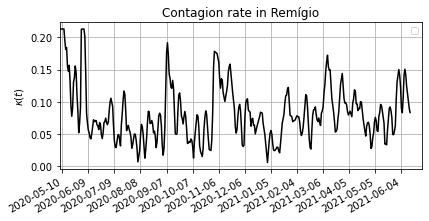

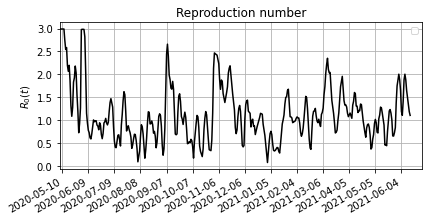

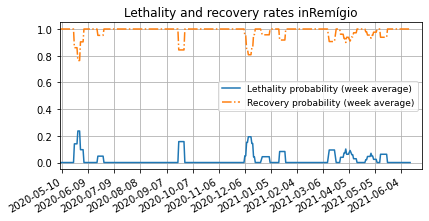

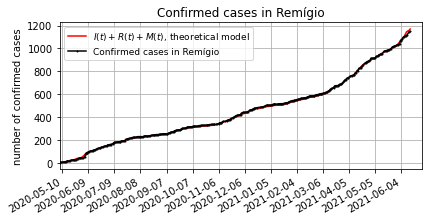

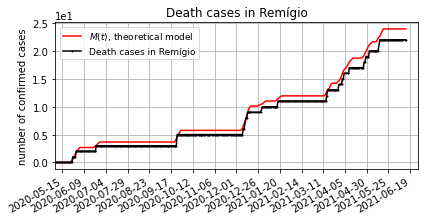

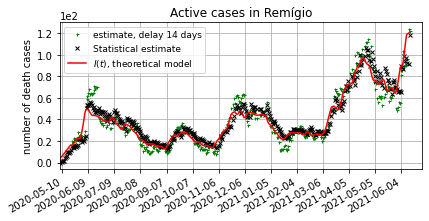

In [6]:
dados = np.array([['state', 'PB'],
  ['city', 'Remígio'],
  ['delay','14'],
  ['offset','2'],
  ['cutoff', '0.213']])

def read_setup(inSetupFile):
  # open SIRM model parameter data 
  # Format of setup file
  # parameter      value
  '''
  state               nome do estado
  city                nome da cidade
  delay               atraso
  offset              outro atraso
  cutoff              valor máximo de k(t)
  '''
  global state, city, delay, offset, cutoff
  # Read setup file
  lines = dados
  # Crie o dicionario
  setup_vars = OrderedDict(lines)
  for var in lines:
    if var[0] == 'state' or var[0] == 'city':
      setup_vars[var[0]] = var[1]
    else:
      if var[1].isdigit():
        setup_vars[var[0]] = int(var[1])
      else:
        setup_vars[var[0]] = float(var[1])
  # Transform the keys into variables
  globals().update(setup_vars)
read_setup(sys.argv[1])

n_avg=delay 
nu = 3.2530e-05 # taxa de natalidade diária (2018, IBGE) 
mu = 2.0047e-05 # taxa de mortalidade diária (2018, IBGE) 
day = 24 # dia em horas
dt = 1.0/day  # em unidade de dia
tau = (1+n_avg*day)*dt # tempo médio de infecção em dias

estados = {
    'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazônia', 'AP':'Amapá', 
    'BA':'Bahia', 'CE':'Ceará', 'DF':'Distrito Federal', 
    'ES':'Espírito Santo', 'GO':'Goiás', 'MA': 'Maranhão',
    'MG':'Minas Gerais', 'MS':'Mato Grosso do Sul', 'MT':'Mato Grosso',
    'PA':'Pará', 'PB':'Paraíba', 'PR':'Paraná', 'PE':'Pernambuco', 
    'PI':'Piauí', 'RJ':'Rio de Janeiro', 'RN':'Rio Grande do Norte', 
    'RO':'Rondônia', 'RR':'Roraima', 'RS':'Rio Grande do Sul', 
    'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 
    'TO':'Tocantins'}
if city == '_':
  city_state = estados[state]
  city = ''
else:
  city_state = city

# create log file
logFile = 'log'+city+state+'.txt'
# remove white spaces
logFile = logFile.replace(' ','')
f = open(logFile, 'w')
f.write('estado %s, cidade %s, atraso %d, offset %s, cutoff %g\n' 
    % (state,  city, delay, offset, cutoff))
##########################################################
# 1. Data processing
# File caso.csv obtained from the site https://data.brasil.io/dataset/covid19/_meta/list.html
# or download directly with the command:
# wget https://data.brasil.io/dataset/covid19/caso.csv.gz
arquivo_csv = '/content/drive/MyDrive/caso.csv'
Recuperados = pd.read_csv('/content/drive/MyDrive/20210610_150220.csv')
recuperados = Recuperados['recuperados']
dados = pd.read_csv(arquivo_csv, sep =',', skiprows=0, header=0, parse_dates=['date'])
#dados = pd.read_csv(arquivo_csv, sep =',', skiprows=0, header=0, names=['date','state', 'city', 'place_type', 'confirmed', 'deaths','order_for_place','is_last', 'estimated_population_2019', 'estimated_population', 'city_ibge_code', 'confirmed_per_100k_inhabitants', 'death_rate'], parse_dates=['date'])
dados = dados[dados['state'].str.contains(state)]
if city == '':
  dados = dados[dados['city'].isnull()]
else:
  dados = dados[~dados.isin([np.nan]).any(1)]
  dados = dados[dados['city'].str.contains(city)]

dados = dados.sort_values('date', ascending=True)
confirmed = dados['confirmed'].to_numpy().astype(int)
deaths = dados['deaths'].to_numpy().astype(int)
ind0 = (confirmed!=0).argmax()
dates = pd.to_datetime(dados.date)
dates = dates[ind0:]
indFirstDeath = (deaths!=0).argmax()
f.write('indFirstDeath %d, First death on %s, number of deaths %d\n'
  % (indFirstDeath, dates.iloc[indFirstDeath], deaths[indFirstDeath]))
ind0 += offset
confirmed = confirmed[ind0:]
deaths = deaths[ind0:]
f.write('ind0 %d, offset %d\n' % (ind0, offset))
dates = dates[offset:]
P_0 = dados['estimated_population_2019'].to_numpy(dtype=int)[0]
f.write('População em 2019 %d\n' % (P_0))

n_max = len(confirmed)-1 # em dias
tt = np.arange(0.0, n_max, dt)
recuperados = recuperados[len(confirmed):0:-1]
ativos = confirmed-(recuperados+deaths)
# 2. Statistical analysis
# Active cases delay estimate
activeDelay = confirmed[delay:]-confirmed[:-delay]
# Active cases statistical estimate
q = (n_avg)/(1+n_avg) # probability to remain sick after 1 day
newConf = np.diff(confirmed) # casos novos confirmados ao dia
newDead = np.diff(deaths) # casos novos confirmados ao dia
N = len(newConf)
active_stat = np.ones(N)
n_pow = np.arange(N)
n_pow_des = n_pow[::-1]
q_to_n = q**n_pow_des
for i in n_pow:
  active_stat[i] = np.sum(newConf[:i]*q_to_n[N-i:])

# 3. Parameter estimation
# a. Contagion rate function
contagionRate = []
S = (P_0-confirmed)/P_0
N_as = len(active_stat)
for i in np.arange(0, N_as):
  if i+7<=N_as:
    XX = np.arange(i, i+7)
    ZZ = active_stat[i:i+7]
  else:
    XX = np.arange(i-7, i)
    ZZ = active_stat[i-7:i]
  if len(XX)==len(ZZ):
    slope, intercept, r_value, p_value, std_err = stats.linregress(XX, ZZ)
    I_avg = np.sum(ZZ)/7
    if I_avg==0:
      ka_t=0
    else:
      ka_t = (1/S[i])*(slope/I_avg+1.0/tau+mu)
    if ka_t<0:
      ka_t = 0
    elif ka_t>cutoff:
      ka_t = cutoff
    contagionRate.append(ka_t)

##########################################################
# Contagion rate function
##########################################################
def kappa(t):
  ind = int(1.0*t)
  N=len(contagionRate)
  if ind>=N:
    ind = N-1
  ka = contagionRate[ind]
  if ind>0 and ind<N and ka==0:
    ka = (contagionRate[ind-1]+contagionRate[ind+1])/2
  return ka
##########################################################
# Vectorize the contagion rate
kappa_t_vec = []
for ind, t in enumerate(tt[::day]):
  ka = kappa(t)
  kappa_t_vec.append(ka)
kappa_t_vec = np.array(kappa_t_vec)

# Lethality probability
P_let = np.zeros(N)
for i in n_pow[:-1]:
    denom = np.sum(newConf[:i]*q_to_n[N-i:])
    if denom>0:
      s = newDead[i]/denom
    else:
      s=0
    P_let[i] = s/(1-q)
f.write('first P_let avg %g\n' % (np.sum(P_let[:21])/21))
f.write('last P_let avg %g\n' % (np.sum(P_let[-21:])/21))

# week average
Pl_avg = np.convolve(P_let, np.ones((7,))/7, mode='same')
# Lethality and recovery rates
letRate = Pl_avg/tau
recRate = 1.0/tau-letRate

# Numerical model epidemic evolution (modified SIR model)
##########################################################
# Get lethality and recovery rates
def get_l_r(t):
  ind = int(1.0*t)
  N = len(Pl_avg)
  if ind>=N:
    ind = N-1
  la = Pl_avg[ind]/tau
  rho = 1.0/tau - la
  return la, rho
##########################################################
def derivs (x, t): # return derivatives of the array x
   S = x[0] # susceptíveis
   I = x[1] # infectados
   R = x[2] # Recuperados
   M = x[3] # Mortos
   T = S+I+R
   l, r = get_l_r(t)
   dSdt = nu*T-mu*S-kappa(t)*S*I
   dIdt = -mu*I+kappa(t)*S*I-r*I-l*I
   dRdt = r*I-mu*R
   dMdt = l*I
   return [dSdt, dIdt, dRdt, dMdt]
##########################################################
C_0 = confirmed[0]
R_0 = 0.0
D_0 = deaths[0]
A_0 = C_0-R_0-D_0
f.write('C_0 %g, A_0 %g, R_0 %g, D_0 %g\n' % (C_0, A_0, R_0, D_0))
yinit = [1.0-C_0/P_0, A_0/P_0, R_0/P_0, D_0/P_0] # initial values
y = scipy.integrate.odeint(derivs, yinit, tt)
S = y[:, 0]
I = y[:, 1]
R = y[:, 2]
M = y[:, 3]

#################### GENERATE R(t) #######################

R0_t = tau*kappa_t_vec*S[::day]

#################### Plot results ######################

############## Contagion rate estimate #################

fig1, ax1 = plt.subplots(1, figsize=(6.5, 3) , sharex=True)

ax1.plot(dates[1:], kappa_t_vec, 'k-', ms=2)

ax1.set_ylabel(r'$\kappa(t)$')
ax1.set_title('Contagion rate in %s' % city_state)

delta = timedelta(days=14                  )
ax1.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Kappa %s_%s.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')


######### DYNAMIC REPRODUCTIVE NUMBER R_0(t)##########

fig2, ax2 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

ax2.plot(dates[1:], R0_t, 'k-')
ax2.set_ylabel(r'$R_0(t)$')
ax2.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax2.set_title('Reproduction number')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Reproduction number.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

########### Lethality probability, P_lambda(t), and recovery probability, P_rho(t) #######
fig3, ax3 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

ax3.plot(dates[1:], Pl_avg, '-', linewidth=1.5, label="Lethality probability (week average)")
ax3.plot(dates[1:], 1-Pl_avg, '-.', linewidth=1.5,  label="Recovery probability (week average)")

#ax3.set_xlabel()
#ax3.set_ylabel()

ax3.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax3.set_ylim()

ax3.set_title(u'Lethality and recovery rates in%s' % (city_state))

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Lethality_and_recovery_rates .jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

##############  CONFIRMED CASES ################

fig4, ax4 = plt.subplots(1, figsize=(6.5, 3), sharex=True)

C= P_0*(I+R+M)
ax4.plot(dates[1:], C[::day], 'r-', label=r"$I(t)+R(t)+M(t)$, theoretical model")
ax4.plot(dates, confirmed, 'k-o', ms=1,  label= u"Confirmed cases in %s" % (city_state))

#ax.set_xlabel()
ax4.set_ylabel(u'number of confirmed cases')

ax4.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

ax4.set_title(u"Confirmed cases in %s" % (city_state))

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Confirmedcases.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')
f.write('%s\n' % figure)

################### DEATHS CASES ###################

fig5, ax5 = plt.subplots(1, figsize=(6.5, 3), sharex=True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) #Deixar em notação científica

ax5.plot(dates[1:], P_0*M[::day], 'r-', label=u"$M(t)$, theoretical model")
ax5.plot(dates, deaths, 'k-o', ms=1,  label= u"Death cases in %s" % (city_state))

#ax.set_xlabel()
ax5.set_ylabel(u'number of confirmed cases')

ax5.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

ax5.set_title(u"Death cases in %s" % (city_state))

ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax5.xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Death_cases.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')
f.write('%s\n' % figure)

######################  ACTIVE CASES ############################
fig6, ax6 = plt.subplots(1, figsize=(6.5, 3), sharex=True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) #Deixar em notação científica
#ax6.yaxis.set_ticks(np.arange(min(P_0*I[::day]), max(P_0*I[::day])+1, max(P_0*I[::day])/15 ))

ax6.plot(dates[delay:], activeDelay, 'g+', ms=3,  label= 'estimate, delay %d days' % delay)
ax6.plot(dates[1:], active_stat, 'kx', ms=4,  label= 'Statistical estimate')
ax6.plot(dates[:-1], P_0*I[::day], 'r-', label=u"$I(t)$, theoretical model")

#ax6.set_xlabel()
ax6.set_ylabel(u'number of death cases')

ax6.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax6.set_ylim()

ax6.set_title(u"Active cases in %s" % (city_state))

ax6.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax6.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=9)
figure = f'{city}_{state}: Active_cases.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=300, bbox_inches='tight')

plt.show()

In [7]:
"""
dados = np.array([['state', 'PB'],
  ['city', 'Remígio'],
  ['delay','14'],
  ['offset','2'],
  ['cutoff', '0.213']])

def read_setup(inSetupFile):
  # open SIRM model parameter data 
  # Format of setup file
  # parameter      value
  '''
  state               nome do estado
  city                nome da cidade
  delay               atraso
  offset              outro atraso
  cutoff              valor máximo de k(t)
  '''
  global state, city, delay, offset, cutoff
  # Read setup file
  lines = dados
  # Crie o dicionario
  setup_vars = OrderedDict(lines)
  for var in lines:
    if var[0] == 'state' or var[0] == 'city':
      setup_vars[var[0]] = var[1]
    else:
      if var[1].isdigit():
        setup_vars[var[0]] = int(var[1])
      else:
        setup_vars[var[0]] = float(var[1])
  # Transform the keys into variables
  globals().update(setup_vars)
read_setup(sys.argv[1])

n_avg=delay 
nu = 3.2530e-05 # taxa de natalidade diária (2018, IBGE) 
mu = 2.0047e-05 # taxa de mortalidade diária (2018, IBGE) 
day = 24 # dia em horas
dt = 1.0/day  # em unidade de dia
tau = (1+n_avg*day)*dt # tempo médio de infecção em dias

estados = {
    'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazônia', 'AP':'Amapá', 
    'BA':'Bahia', 'CE':'Ceará', 'DF':'Distrito Federal', 
    'ES':'Espírito Santo', 'GO':'Goiás', 'MA': 'Maranhão',
    'MG':'Minas Gerais', 'MS':'Mato Grosso do Sul', 'MT':'Mato Grosso',
    'PA':'Pará', 'PB':'Paraíba', 'PR':'Paraná', 'PE':'Pernambuco', 
    'PI':'Piauí', 'RJ':'Rio de Janeiro', 'RN':'Rio Grande do Norte', 
    'RO':'Rondônia', 'RR':'Roraima', 'RS':'Rio Grande do Sul', 
    'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 
    'TO':'Tocantins'}
if city == '_':
  city_state = estados[state]
  city = ''
else:
  city_state = city

# create log file
logFile = 'log'+city+state+'.txt'
# remove white spaces
logFile = logFile.replace(' ','')
f = open(logFile, 'w')
f.write('estado %s, cidade %s, atraso %d, offset %s, cutoff %g\n' 
    % (state,  city, delay, offset, cutoff))
##########################################################
# 1. Data processing
# File caso.csv obtained from the site https://data.brasil.io/dataset/covid19/_meta/list.html
# or download directly with the command:
# wget https://data.brasil.io/dataset/covid19/caso.csv.gz
arquivo_csv = '/content/drive/MyDrive/caso.csv'
Recuperados = pd.read_csv('/content/drive/MyDrive/20210610_150220.csv')
recuperados = Recuperados['recuperados']
dados = pd.read_csv(arquivo_csv, sep =',', skiprows=0, header=0, parse_dates=['date'])
#dados = pd.read_csv(arquivo_csv, sep =',', skiprows=0, header=0, names=['date','state', 'city', 'place_type', 'confirmed', 'deaths','order_for_place','is_last', 'estimated_population_2019', 'estimated_population', 'city_ibge_code', 'confirmed_per_100k_inhabitants', 'death_rate'], parse_dates=['date'])
dados = dados[dados['state'].str.contains(state)]
if city == '':
  dados = dados[dados['city'].isnull()]
else:
  dados = dados[~dados.isin([np.nan]).any(1)]
  dados = dados[dados['city'].str.contains(city)]

dados = dados.sort_values('date', ascending=True)
confirmed = dados['confirmed'].to_numpy().astype(int)
deaths = dados['deaths'].to_numpy().astype(int)
ind0 = (confirmed!=0).argmax()
dates = pd.to_datetime(dados.date)
dates = dates[ind0:]
indFirstDeath = (deaths!=0).argmax()
f.write('indFirstDeath %d, First death on %s, number of deaths %d\n'
  % (indFirstDeath, dates.iloc[indFirstDeath], deaths[indFirstDeath]))
ind0 += offset
confirmed = confirmed[ind0:]
deaths = deaths[ind0:]
f.write('ind0 %d, offset %d\n' % (ind0, offset))
dates = dates[offset:]
P_0 = dados['estimated_population_2019'].to_numpy(dtype=int)[0]
f.write('População em 2019 %d\n' % (P_0))

n_max = len(confirmed)-1 # em dias
tt = np.arange(0.0, n_max, dt)
recuperados = recuperados[len(confirmed):0:-1]
ativos = confirmed-(recuperados+deaths)
# 2. Statistical analysis
# Active cases delay estimate
activeDelay = confirmed[delay:]-confirmed[:-delay]
# Active cases statistical estimate
q = (n_avg)/(1+n_avg) # probability to remain sick after 1 day
newConf = np.diff(confirmed) # casos novos confirmados ao dia
newDead = np.diff(deaths) # casos novos confirmados ao dia
N = len(newConf)
active_stat = np.ones(N)
n_pow = np.arange(N)
n_pow_des = n_pow[::-1]
q_to_n = q**n_pow_des
for i in n_pow:
  active_stat[i] = np.sum(newConf[:i]*q_to_n[N-i:])

# 3. Parameter estimation
# a. Contagion rate function
contagionRate = []
S = (P_0-confirmed)/P_0
N_as = len(active_stat)
for i in np.arange(0, N_as):
  if i+7<=N_as:
    XX = np.arange(i, i+7)
    ZZ = active_stat[i:i+7]
  else:
    XX = np.arange(i-7, i)
    ZZ = active_stat[i-7:i]
  if len(XX)==len(ZZ):
    slope, intercept, r_value, p_value, std_err = stats.linregress(XX, ZZ)
    I_avg = np.sum(ZZ)/7
    if I_avg==0:
      ka_t=0
    else:
      ka_t = (1/S[i])*(slope/I_avg+1.0/tau+mu)
    if ka_t<0:
      ka_t = 0
    elif ka_t>cutoff:
      ka_t = cutoff
    contagionRate.append(ka_t)

##########################################################
# Contagion rate function
##########################################################
def kappa(t):
  ind = int(1.0*t)
  N=len(contagionRate)
  if ind>=N:
    ind = N-1
  ka = contagionRate[ind]
  if ind>0 and ind<N and ka==0:
    ka = (contagionRate[ind-1]+contagionRate[ind+1])/2
  return ka
##########################################################
# Vectorize the contagion rate
kappa_t_vec = []
for ind, t in enumerate(tt[::day]):
  ka = kappa(t)
  kappa_t_vec.append(ka)
kappa_t_vec = np.array(kappa_t_vec)

# Lethality probability
P_let = np.zeros(N)
for i in n_pow[:-1]:
    denom = np.sum(newConf[:i]*q_to_n[N-i:])
    if denom>0:
      s = newDead[i]/denom
    else:
      s=0
    P_let[i] = s/(1-q)
f.write('first P_let avg %g\n' % (np.sum(P_let[:21])/21))
f.write('last P_let avg %g\n' % (np.sum(P_let[-21:])/21))

# week average
Pl_avg = np.convolve(P_let, np.ones((7,))/7, mode='same')
# Lethality and recovery rates
letRate = Pl_avg/tau
recRate = 1.0/tau-letRate

# Numerical model epidemic evolution (modified SIR model)
##########################################################
# Get lethality and recovery rates
def get_l_r(t):
  ind = int(1.0*t)
  N = len(Pl_avg)
  if ind>=N:
    ind = N-1
  la = Pl_avg[ind]/tau
  rho = 1.0/tau - la
  return la, rho
##########################################################
def derivs (x, t): # return derivatives of the array x
   S = x[0] # susceptíveis
   I = x[1] # infectados
   R = x[2] # Recuperados
   M = x[3] # Mortos
   T = S+I+R
   l, r = get_l_r(t)
   dSdt = nu*T-mu*S-kappa(t)*S*I
   dIdt = -mu*I+kappa(t)*S*I-r*I-l*I
   dRdt = r*I-mu*R
   dMdt = l*I
   return [dSdt, dIdt, dRdt, dMdt]
##########################################################
C_0 = confirmed[0]
R_0 = 0.0
D_0 = deaths[0]
A_0 = C_0-R_0-D_0
f.write('C_0 %g, A_0 %g, R_0 %g, D_0 %g\n' % (C_0, A_0, R_0, D_0))
yinit = [1.0-C_0/P_0, A_0/P_0, R_0/P_0, D_0/P_0] # initial values
y = scipy.integrate.odeint(derivs, yinit, tt)
S = y[:, 0]
I = y[:, 1]
R = y[:, 2]
M = y[:, 3]

#################### GENERATE R(t) #######################

R0_t = tau*kappa_t_vec*S[::day]

#################### Plot results ######################

############## Contagion rate estimate #################


fig1, ax1 = plt.subplots(1, figsize=(5, 3), sharex=True)

ax1.plot(dates[1:], kappa_t_vec, 'k-', ms=0.5)

ax1.set_ylabel(r'$\kappa(t)$')
ax1.set_title('Contagion rate in %s' % city_state)

delta = timedelta(days=14                  )
ax1.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=12)
figure = f'{city}_{state}: Kappa %s_%s.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=1200, bbox_inches='tight')


######### DYNAMIC REPRODUCTIVE NUMBER R_0(t)##########

fig2, ax2 = plt.subplots(1, figsize=(13, 5), sharex=True)

ax2.plot(dates[1:], R0_t, 'k-')
ax2.set_ylabel(r'$R_0(t)$')
ax2.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)

ax2.set_title('Reproduction number')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=12)
figure = f'{city}_{state}: Reproduction number %s_%s.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=1200, bbox_inches='tight')

########### Lethality probability, P_lambda(t), and recovery probability, P_rho(t) #######
fig3, ax3 = plt.subplots(1, figsize=(13, 5), sharex=True)

ax3.plot(dates[1:], Pl_avg, '-', linewidth=1.5, label="Lethality probability (week average)")
ax3.plot(dates[1:], 1-Pl_avg, '-.', linewidth=1.5,  label="Recovery probability (week average)")

#ax3.set_xlabel()
#ax3.set_ylabel()

ax3.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax3.set_ylim()

ax3.set_title(u'Lethality and recovery rates in%s' % (city_state))

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=12)
figure = f'{city}_{state}: Lethality_and_recovery_rates.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=1200, bbox_inches='tight')

##############  CONFIRMED CASES ################

fig4, ax4 = plt.subplots(1, figsize=(5, 3), sharex=True)

C= P_0*(I+R+M)
ax4.plot(dates[1:], C[::day], 'r-', ms = 0.5,label=r"$I(t)+R(t)+M(t)$, Modelo teorico")
ax4.plot(dates, confirmed, 'k-o', ms=0.5,  label= u"Casos confirmados em %s" % (city_state))

#ax.set_xlabel()
ax4.set_ylabel(u'Número de casos confimados')

ax4.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

#ax4.set_title(u"Confirmed cases in %s" % (city_state))

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=45))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=10)
figure = 'CONFIRMADOS%s_%s.jpg'% (city, state)
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=200, bbox_inches='tight')
f.write('%s\n' % figure)

################### DEATHS CASES ###################

fig5, ax5 = plt.subplots(1, figsize=(5, 3), sharex=True)

ax5.plot(dates[1:], P_0*M[::day], 'r-', ms=0.5 , label=u"$M(t)$, Modelo teórico")
ax5.plot(dates, deaths, 'k-o', ms=0.5 ,  label= u"Casos de óbitos em %s" % (city_state))

#ax.set_xlabel()
ax5.set_ylabel(u'Número de óbitos')

ax5.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax.set_ylim()

#ax5.set_title(u"Death cases in %s" % (city_state))

ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax5.xaxis.set_major_locator(mdates.DayLocator(interval=45))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=10)
figure = 'OBITOS%s_%s.jpg'% (city, state)
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=200, bbox_inches='tight')
f.write('%s\n' % figure)

######################  ACTIVE CASES ############################
fig6, ax6 = plt.subplots(1, figsize=(13, 5), sharex=True)

ax6.plot(dates[delay:], activeDelay, 'g+', ms=3,  label= 'estimate, delay %d days' % delay)
ax6.plot(dates[1:], active_stat, 'kx', ms=4,  label= 'Statistical estimate')
ax6.plot(dates[:-1], P_0*I[::day], 'r-', label=u"$I(t)$, theoretical model")

#ax6.set_xlabel()
ax6.set_ylabel(u'number of death cases')

ax6.set_xlim(dates.iloc[0], dates.iloc[-1]+delta)
#ax6.set_ylim()

ax6.set_title(u"Active cases in %s" % (city_state))

ax6.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax6.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()

plt.legend(fontsize=10)
figure = f'{city}_{state}:Active_cases_%s_%s.jpg'
figure = unidecode.unidecode(figure)
figure = figure.replace(' ','')
plt.savefig(figure, format='jpg', dpi=400, bbox_inches='tight')

plt.show()
"""

'\ndados = np.array([[\'state\', \'PB\'],\n  [\'city\', \'Remígio\'],\n  [\'delay\',\'14\'],\n  [\'offset\',\'2\'],\n  [\'cutoff\', \'0.213\']])\n\ndef read_setup(inSetupFile):\n  # open SIRM model parameter data \n  # Format of setup file\n  # parameter      value\n  \'\'\'\n  state               nome do estado\n  city                nome da cidade\n  delay               atraso\n  offset              outro atraso\n  cutoff              valor máximo de k(t)\n  \'\'\'\n  global state, city, delay, offset, cutoff\n  # Read setup file\n  lines = dados\n  # Crie o dicionario\n  setup_vars = OrderedDict(lines)\n  for var in lines:\n    if var[0] == \'state\' or var[0] == \'city\':\n      setup_vars[var[0]] = var[1]\n    else:\n      if var[1].isdigit():\n        setup_vars[var[0]] = int(var[1])\n      else:\n        setup_vars[var[0]] = float(var[1])\n  # Transform the keys into variables\n  globals().update(setup_vars)\nread_setup(sys.argv[1])\n\nn_avg=delay \nnu = 3.2530e-05 # taxa de nat